# Train

Train models and find optimal parameters using cross validation.

The models are:
1. `Oracle`. Needs no training.
2. `Mean`. Needs no training.
3. `DemWeight`. Learn weights over the training set.
4. `HitWeight`. Optimize `beta` using CV and learn weights.
5. `ScoreWeight`. Optimize `beta` using CV and learn weights.
6. `KDemWeight`. Optimize `k` using CV and learn weights.
7. `MPWeight`. Optimize `eta` using CV.

For all the models with learning requirements, we will use leave one season out cross validation scheme to find optimal parameters and then save a model dump using weights trained from the complete training data.

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(1234)

import sys
sys.path.append("../src")
from utils import data as udata
from utils import dists as udists
from utils import misc as u
from tqdm import tqdm, trange
import models
import inspect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
EXP_DIR = "../data/processed/cdc-flusight-ensemble/"
TARGET = "4-ahead"
REGION = None
TRAINING_SEASONS = list(range(2010, 2014))

In [3]:
components = [udata.Component(EXP_DIR, m) for m in udata.available_models(EXP_DIR)]
ad = udata.ActualData(EXP_DIR)

## Data partition

We have training data from the set [2010, 2016]. From these, we use [2010, 2013] for training and CV.

In [4]:
def get_seasons_data(seasons):
    """
    Return a tuple of yi, y and Xs for the givens seasons, concatenated.
    """
    
    ypairs = [ad.get(TARGET, region_name=REGION, season=s) for s in seasons]
    yi = pd.concat([yp[0] for yp in ypairs], ignore_index=True)
    y = np.concatenate([yp[1] for yp in ypairs])
    
    Xs = [
        np.concatenate([c.get(TARGET, region_name=REGION, season=s)[1] for s in seasons])
        for c in components
    ]
    
    return yi, y, Xs

## Evaluation

We evaluate the models on the left out season and take mean across all such evaluations.

In [5]:
def evaluate_season(model, season):
    """
    Return score and model predictions for given season
    """
    
    yi, y, Xs = get_seasons_data([season])
    predictions = np.zeros_like(Xs[0])

    for i in range(len(yi)):
        # HACK: Check if this is an oracle
        # This should ideally go in as a flag in the model
        if "truth" in inspect.signature(model.predict).parameters:
            # This is an oracle
            predictions[i, :] = model.predict(yi.iloc[i], [X[i] for X in Xs], y[i])
        else:
            predictions[i, :] = model.predict(yi.iloc[i], [X[i] for X in Xs]) 
        # Pass in feedback if model accepts it
        try:
            model.feedback(y[i])
        except NotImplementedError:
            pass

    score = np.log(udists.prediction_probabilities([predictions], y, TARGET)).mean()
    return score, predictions

def cross_validate(model):
    """
    Run cross validation and return mean score
    """
    
    cv_scores = []
    train_scores = []
    for season in tqdm(TRAINING_SEASONS):
        train_seasons = [s for s in TRAINING_SEASONS if s != season]
        yi, y, Xs = get_seasons_data(train_seasons)
        model.train(yi, Xs, y)
        for ts in train_seasons:
            score, _= evaluate_season(model, ts)
            train_scores.append(score)
        
        score, _ = evaluate_season(model, season)
        cv_scores.append(score)

    return np.mean(train_scores), np.mean(cv_scores)

# Cross validation

## Oracle model
This is the oracle model which sets the upper limit for prediction

In [6]:
cross_validate(models.OracleEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:38<00:00,  9.61s/it]


(-2.0852054490336465, -2.085205449033647)

## Mean ensemble
Return the mean of component predictions. It kind of sets the lower limit since we should be able to beat the mean at the very least.

In [7]:
cross_validate(models.MeanEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


(-3.235595801146737, -3.235595801146738)

## Degenerate EM
This trains weights for each component using degenerate EM. It doesn't take into account the current week.

In [8]:
cross_validate(models.DemWeightEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


(-3.076101955235282, -3.10207780379167)

## K-partition Degenerate EM
Here we partition the list of model weeks in k partitions and run degenerate EM on each of these. While predicting, we check in which partition the instance belongs (using its model week) and then use that partition's weights for generating predictions.

In the case of k = 1, this is equivalent to simple degenerate EM. When k=len(model_weeks), this is equivalent to learning weights per week (this would still not be oracular since, for a week, we might have more instances if we consider more than one region).

In [16]:
cv_scores = []
t_scores = []
for k in range(1, 30):
    ts, cs = cross_validate(models.KDemWeightEnsemble(TARGET, len(components), k))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


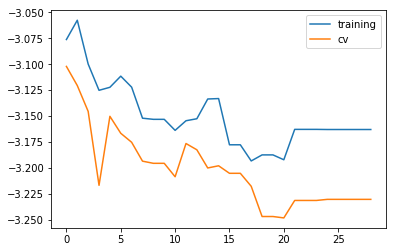

In [20]:
plt.plot(t_scores, label="training")
plt.plot(cv_scores, label="cv")
plt.legend()

In [22]:
# ^ looks like there is some issue with the k partition model
# Training scores should always be better than that of plain
# dem (-3.076101955235282)

## Hit weight ensemble
This is a toy model which uses the number of times a model is best (hit) among the lot to assign its weight. Its basically a sharper weight assignment scheme than the score weight ensemble. Additionally, since we have less data (and so the hits are sparse), this model doesn't learn different weights for different model weeks.

In [25]:
cv_scores = []
t_scores = []
betas = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 1.0, 2.0, 5.0]
for beta in betas:
    ts, cs = cross_validate(models.HitWeightEnsemble(TARGET, len(components), beta))
    cv_scores.append(cs)
    t_scores.append(ts)

  0%|          | 0/4 [00:00<?, ?it/s]../src/models.py:24: RuntimeWarning: overflow encountered in exp
  expv = np.exp(beta * vector)
../src/models.py:25: RuntimeWarning: invalid value encountered in true_divide
  return expv / np.sum(expv)
100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


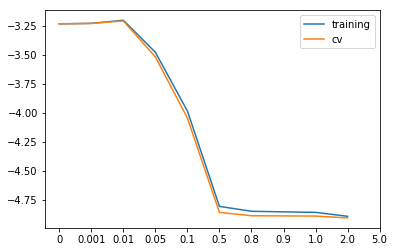

In [29]:
plt.plot(t_scores, label="training")
plt.plot(cv_scores, label="cv")
plt.xticks(range(len(t_scores)), betas)
plt.legend()

## Score weight ensemble
Here we learn one set of weights for each model week using the value of model score.

In [30]:
cv_scores = []
t_scores = []
betas = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 1.0, 2.0, 5.0]
for beta in betas:
    ts, cs = cross_validate(models.ScoreWeightEnsemble(TARGET, len(components), beta))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


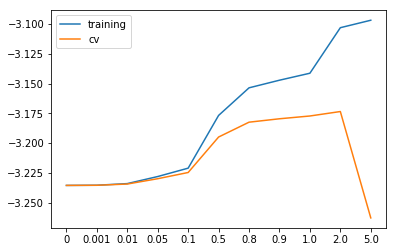

In [31]:
plt.plot(t_scores, label="training")
plt.plot(cv_scores, label="cv")
plt.xticks(range(len(t_scores)), betas)
plt.legend()

## Multiplicative weight
This adapts the model weights according to past performance by hedging.

In [ ]:
# TODO: Fix underflow
cross_validate(models.MPWeightEnsemble(TARGET, len(components), 0.1))